# Extraction of electrical features (eFeatures) from experimental data

____

## Overview

____

In this tutorial we will see how to extract electrical features (eFeatures), such as spike amplitude, firing frequency, etc... from experimental traces. The eFeatures describe the electrical behavior our neuron model should reproduce.

The steps we will follow are:

* Select and visualize the data.

* Electrophysiological features will be extracted from the voltage traces, thanks to the ** Electrophys Feature Extraction Library ** [eFEL](https://github.com/BlueBrain/eFEL).

* We will use experimental current traces to create protocols that we will use to simulate our neuron model.

* In future weeks we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/). There you'll see how the morphology you've chosen, the eFeatures and the stimuli will be combined in setting up the optimization of your neuron model.

In [1]:
# First install the pacakges you will need.
#! pip install --upgrade pip
#! pip install json2html
# First execute this line to upgrade pip
#! pip install -q --upgrade "hbp-service-client==1.0.0"

__RESTART YOUR KERNEL NOW!__

Now, we can import some useful Python modules.

In [2]:
%load_ext autoreload
%autoreload

import numpy, IPython
import json, os

import matplotlib.pyplot as plt
%matplotlib notebook

import collections

from json2html import *

# 1. Electrophysiology data
In this section we will process the electrophysiological data recorded with patch clamp (current clamp) experiments.

Please, go to the __MOODLE__ and download the __.dat__ files. Then, save these files in the __Storage__ of your collab. There are a lot of files (exactly 152), so is better to create a folder in the Storage and save the files in the folder. I called the folder __"week6_data"__

In [3]:
import os

In [4]:
# Download the files from the Storage to your collab virtual machine
# Save the file's names in a list
# Be patient it could take some minutes...

# These lines allow us to take and work with the desired files in the storage.
#clients = get_hbp_service_client()
#collab_path = get_collab_storage_path()
#data_dir = collab_path + '/week6_data/'
data_dir ='data/week6/measures/'

#print files_list
#project_uuid = clients.storage.api_client.get_entity_by_query(path=data_dir)['uuid']
#l = clients.storage.api_client.list_folder_content(project_uuid, page_size=200)

#filenames = []
#for e in l['results']:
#    filenames.append(e['name'])

filenames = os.listdir(data_dir)

for filename in filenames:
    print filename
#    path_to_file = '/tmp/downloaded_'+filename
#    file_from_path = data_dir+filename
#    clients.storage.download_file(str(data_dir+filename), str(path_to_file))


exp_IV_ch7_1033.dat
exp_IV_ch6_1033.dat
exp_IV_ch7_3036.dat
exp_APWaveform_ch6_49.dat
exp_IV_ch6_3036.dat
exp_IV_ch6_3037.dat
exp_APWaveform_ch6_48.dat
exp_IV_ch7_3037.dat
exp_IV_ch6_1032.dat
exp_IV_ch7_1032.dat
exp_IV_ch6_38.dat
exp_IV_ch7_44.dat
exp_IV_ch6_3035.dat
exp_IV_ch7_3035.dat
exp_FirePattern_ch6_52.dat
exp_FirePattern_ch6_53.dat
exp_IV_ch7_3034.dat
exp_IV_ch6_3034.dat
exp_IV_ch7_45.dat
exp_IV_ch7_1031.dat
exp_IV_ch6_1031.dat
exp_IV_ch6_39.dat
exp_IV_ch6_1035.dat
exp_IV_ch7_1035.dat
exp_IV_ch7_41.dat
exp_IV_ch7_3031.dat
exp_IV_ch6_3031.dat
exp_IV_ch7_40.dat
exp_IV_ch7_1034.dat
exp_IV_ch6_1034.dat
exp_IV_ch7_1036.dat
exp_IV_ch6_1036.dat
exp_IV_ch7_42.dat
exp_IV_ch7_3033.dat
exp_IV_ch6_3033.dat
exp_IV_ch6_3032.dat
exp_IV_ch7_3032.dat
exp_IV_ch7_43.dat
exp_IV_ch6_1037.dat
exp_IV_ch7_1037.dat
exp_APWaveform_ch6_2046.dat
exp_APWaveform_ch7_2046.dat
exp_IV_ch6_3041.dat
exp_IV_ch7_3041.dat
exp_IV_ch7_3040.dat
exp_IV_ch6_3040.dat
exp_APWaveform_ch7_2047.dat
exp_APWaveform_ch6_2047.da

___
### Traces description

* All the recordings you see above represent different **stimuli** (e.g. "APWaveform", "FirePattern", "IV"). 
* Each stimulus comprises different **sweeps** (e.g. "APWaveform*46-51"), of increasing/decreasing amplitudes.
* Each stimulus is repeated multiple times (e.g. APWaveform 46-51, 1042-1047, 2042-2047, 3042-3047 ). In the example above we have four **repetitions** of each stimulus.

Any individual recording has a trace number (e.g. "_1046"). Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch7_51.dat" and "exp_APWaveform_ch6_51.dat"). One of them contains the current stimulus (in this case "*ch7*") and the other the voltage response (in this case "*ch6*").
___

For this example we have chosen to use one negative current step `LongStepNeg` and two positive current steps with different durations `ShortStepPos, LongStepPos`. 

We can, for example, select a sweep from a stimulus (in this case the one with the highest amplitude) and some repetitions.

With the code below we can, for example, select traces based on trace number and store them in Python dictionaries.

In [5]:
selected_traces = [1047, 2047, 3047, 1049, 2049, 3049, 1041, 2041, 3041]

# Store voltage data in a dictionary step_name : [list of repetitions]
steps_v_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Store current data in a dictionary step_name : [list of repetitions]
steps_i_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})


for file_name in filenames:
    # Get channel and trace number from the file_name
    channel = int(file_name[:-4].split('_')[2][2:])
    tracenum = int(file_name[:-4].split('_')[-1])
    path_to_file = 'data/week6/measures/' + file_name
    
    # Even channel numbers are voltage traces in this case
    if channel % 2 == 0:
        if "APWaveform" in file_name and tracenum in selected_traces:
            steps_v_dict['ShortStepPos'].append(numpy.fromfile(path_to_file))
        if "FirePattern" in file_name and tracenum in selected_traces:
            steps_v_dict['LongStepPos'].append(numpy.fromfile(path_to_file))
        if "IV" in file_name and tracenum in selected_traces:
            steps_v_dict['LongStepNeg'].append(numpy.fromfile(path_to_file))
            
    # Odd channel numbers are voltage traces in this case        
    elif channel % 2 == 1:
        if "APWaveform" in file_name and tracenum in selected_traces:
            steps_i_dict['ShortStepPos'].append(numpy.fromfile(path_to_file))
        if "FirePattern" in file_name and tracenum in selected_traces:
            steps_i_dict['LongStepPos'].append(numpy.fromfile(path_to_file))
        if "IV" in file_name and tracenum in selected_traces:
            steps_i_dict['LongStepNeg'].append(numpy.fromfile(path_to_file))


We can now plot these traces.

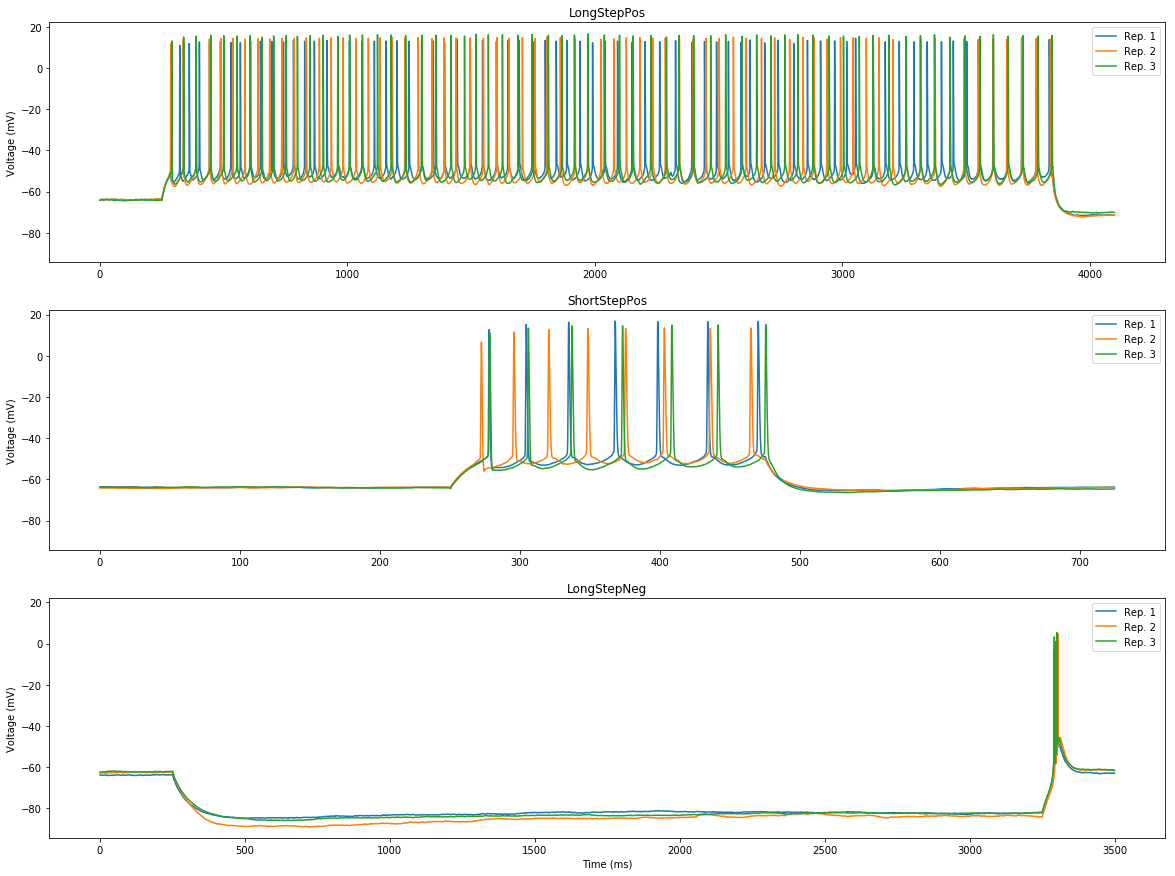

In [6]:
# Initialize a figure
fig1, axes = plt.subplots(len(steps_v_dict), sharey = True, figsize=(20,15))

# Plot the voltage traces
for idx, step_name in enumerate(steps_v_dict.keys()):
    for rep, trace in enumerate(steps_v_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')

# 2. Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The metrics we use are the **eFeatures**, which measure the parameters describing, for instance, the shape of the action potential or the firing properties of a neuron (see [here](http://bluebrain.github.io/eFEL/eFeatures.html) for *eFeatures* description).

In this particular example, we extract distinct features from the three types of voltage traces.
The *eFeatures* extracted from the data, and later from the model, will be used to evaluate the results of the simulations. The mean features values, along with the standard deviations, will be stored in a .json file.

In [7]:
# Extract features
import efel

# Define stimulus start and end times
steps_info = {'LongStepNeg': [250, 3250], 'ShortStepPos': [250, 475], 'LongStepPos': [250, 3850]}

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:            
            data = rep.reshape(len(rep)/2,2)
            # A single eFEL trace 
            trace = {}
            trace['T'] = data[:,0]
            trace['V'] = data[:,1] 
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['LongStepNeg'] = efel.getMeanFeatureValues(efel_traces['LongStepNeg'], 
                                                                ['time_constant', 'voltage_deflection_begin', 
                                                                'voltage_deflection'])
    
    features_values['LongStepPos'] = efel.getMeanFeatureValues(efel_traces['LongStepPos'], 
                                                               ['mean_frequency', 'adaptation_index2', 
                                                                'ISI_CV', 'doublet_ISI'])
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], 
                                                                ['time_to_first_spike', 'AHP_depth', 
                                                                'AP_width', 'AP_height'])    

    return features_values

We can now visualise the feature values we computed, each row in the table corresponds to a repetition of the same step.

In [8]:
efel_features = dict(get_features(steps_v_dict))
IPython.display.HTML(json2html.convert(json=efel_features))

- **ISI_CV** $= \frac{\sigma_{ISI}}{\mu_{ISI}}$
- **doublet_ISI** $= t_{peak_1} - t_{peak_0}$

We compute features mean and standard deviation.

In [9]:
features_dict = collections.OrderedDict()
for step_name, reps in efel_features.items():
    feature_values = collections.defaultdict(list)
    for rep in reps: 
        for feature_name, value in rep.iteritems():
            feature_values[feature_name].append(value)
   
    features_dict[step_name] = {"soma":{}}
    for name, values in feature_values.items():
        features_dict[step_name]["soma"][name] = [numpy.mean(values), numpy.std(values)]
        
IPython.display.HTML(json2html.convert(json=dict(features_dict)))

We write the eFeatures in a json file that we will use later in the exercise.

In [10]:
with open('data/week6/features.json', 'w') as fp:
    json.dump(features_dict, fp, indent = 4)

In [11]:
# Let's see if we had created the file in the working directory of the collab virtual machine.
#! ls

In [12]:
# Execute the lines below
# This will save the files in the storage
#clients = get_hbp_service_client()
#collab_path = get_collab_storage_path()
#clients.storage.upload_file('features.json', data_dir + '/features.json', 'application/JSON')

___
### Exercise 1 - Plot some spike eFeatures 

Complete the code below in order to extract the 1. action potentials (AP) peak times, 2. their height (maximum overshoot voltage) and 3. the minimum voltage between the spikes of the "LongStepPos" traces and plot them.

The result should be similar to the last figures in this [eFEL example](https://github.com/BlueBrain/eFEL/blob/master/examples/nmc-portal/L5TTPC2.ipynb).
___

In [13]:
# Retrive the LongStepPos traces from the steps_dict dictionary
traces_data = steps_i_dict['LongStepPos']

traces_efel = []

for idx in range(len(traces_data)):
    trace = {}
    data = traces_data[idx].reshape(len(traces_data[idx])/2,2)
    trace['T'] = data[:,0]
    trace['V'] = data[:,1]
    trace['stim_start'] = [steps_info['LongStepPos'][0]]
    trace['stim_end'] = [steps_info['LongStepPos'][1]]
    
    traces_efel.append(trace)

In [14]:
# Use the efel "getFeatureNames" function to find the names
# for the peak times, action potential height and the the AHP absolute depth 

for feature in efel.getFeatureNames():
    if ('height' in feature) or ('depth' in feature) or ('peak' in feature):
       print(feature)

AHP1_depth_from_peak
AHP2_depth_from_peak
AHP_depth
AHP_depth_abs
AHP_depth_abs_slow
AHP_depth_diff
AHP_depth_from_peak
AHP_time_from_peak
AP1_peak
AP2_AP1_peak_diff
AP2_peak
AP_height
peak_indices
peak_time
peak_voltage


/Users/utanashati/miniconda3/envs/silico/lib/python2.7/site-packages/efel/api.py:379: RuntimeWarning: Error while calculating feature AP_height: Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function
Parameter [offset] is missing in double map. In the python interface this can be set using the setDoubleSetting() function

Voltage never goes below or above threshold in spike detection.

Feature [peak_voltage] is missing

  RuntimeWarning)
/Users/utanashati/miniconda3/envs/silico/lib/python2.7/site-packages/efel/api.py:379: RuntimeWarning: Error while calculating feature AHP_depth_abs: 
 At least one spike required for calculation of min_AHP_indices.

Feature [min_AHP_values] is missing

  RuntimeWarning)
/Users/utanashati/miniconda3/envs/silico/lib/python2.7/site-packages/efel/api.py:379: RuntimeWar

[[<matplotlib.lines.Line2D at 0x112f44ed0>],

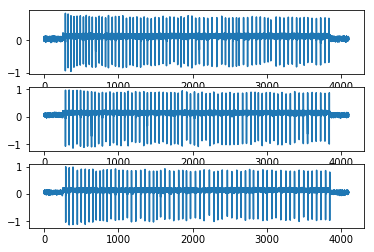

In [15]:
efeatures = efel.getFeatureValues(traces_efel, ['peak_time', 'AP_height', 'AHP_depth_abs']) # Insert here three feature names
fig1, axes = plt.subplots(len(traces_data))

# These are "list comprehensions", a more compat way for writing for loops in Python
[axes[rep].plot(traces_efel[rep]['T'], traces_efel[rep]['V']) for rep in range(len(traces_data))]

# Take inspiration from the line above to plot spike times (x axis) and spike hights (y axis)
#[___ for rep in range(len(traces_data))]

# Take inspiration from the line above to plot spike times (x axis) and AHP depths (y axis)
#[___ for rep in range(len(traces_data))]

## 3. Write out the stimulation protocols

Now it's time to process the current stimuli that were used to record the voltage responses seen above.

We will estimate the stimuli amplitude from the trace and save them in a file "protocols.json". They will be used later on in the project to stimulate your neuron model.

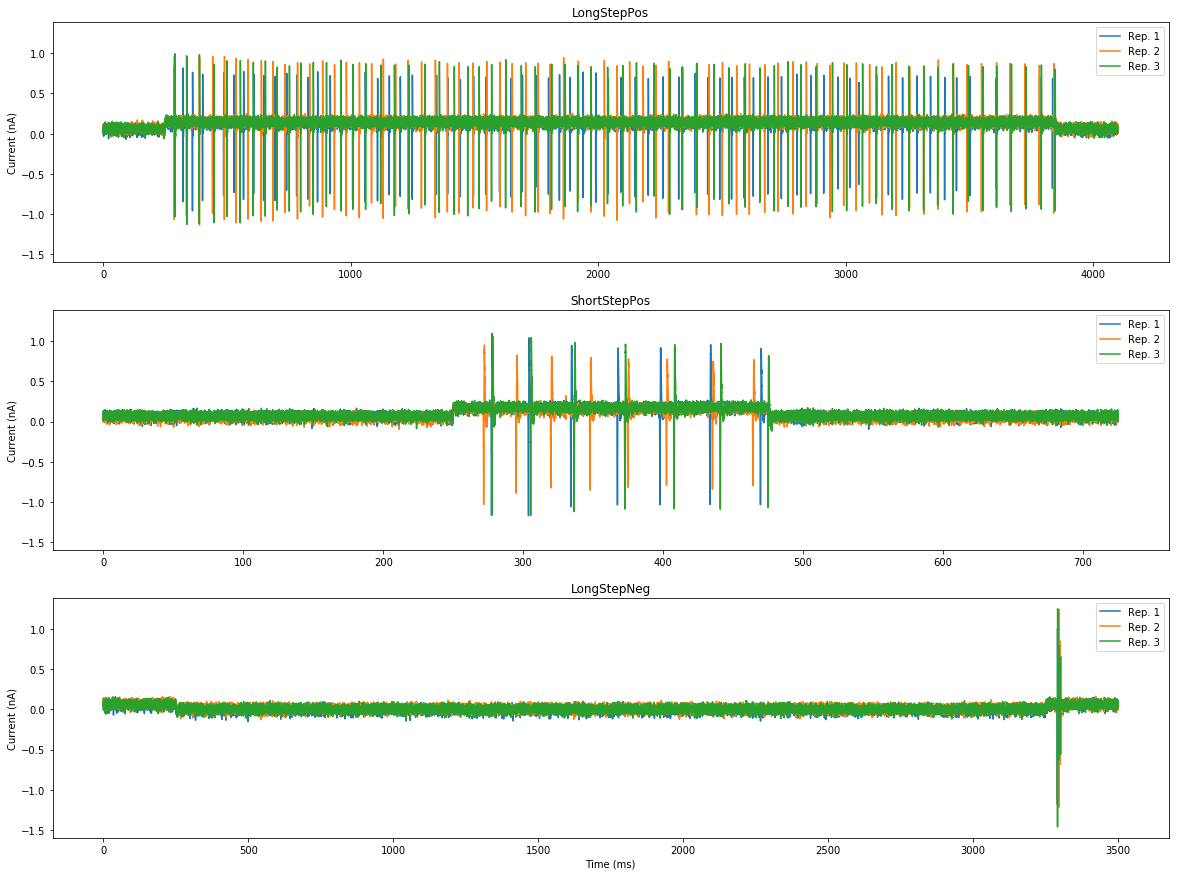

In [16]:
# Plot the current traces
# Initialize a figure
fig1, axes = plt.subplots(len(steps_i_dict), sharey = True, figsize=(20,15))

for idx, step_name in enumerate(steps_i_dict.keys()):
    for rep, trace in enumerate(steps_i_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Current (nA)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')

In [17]:
protocols_dict = collections.OrderedDict()

# Stimuli start and end time
steps_info = {'LongStepNeg': [250, 3250], 'ShortStepPos': [250, 475], 'LongStepPos': [250, 3850]}

# Stimuli holding current and step current amplitudes in nA
amps_info = collections.defaultdict(list)
for step_name in steps_i_dict.keys():
    
    iholds = []
    isteps = []
    for trace in steps_i_dict[step_name]:
        data = trace.reshape(len(trace)/2,2)
        tot_duration = steps_info[step_name][1]+steps_info[step_name][0]
   
        dt = float(tot_duration)/len(data)
        ihold = numpy.mean(data[:,1][0:int(steps_info[step_name][0]/dt)])

        istep = numpy.mean(data[:,1][int(steps_info[step_name][0]/dt):int(steps_info[step_name][1]/dt)])-ihold
        iholds.append(ihold)
        isteps.append(istep)
       
    amps_info[step_name].append(round(numpy.mean(isteps), 4))
    amps_info[step_name].append(round(numpy.mean(iholds), 4)) 
    
#amps_info  = {'LongStepNeg': [-0.01, 0.05], 'ShortStepPos': [0.18,0.05],'LongStepPos': [0.15 ,0.05]}

for step_name, reps in efel_features.items():   
    protocols_dict[step_name] = {"stimuli":[]}
    protocols_dict[step_name]["stimuli"].append({"delay":steps_info[step_name][0],
                                               "amp":amps_info[step_name][0],
                                               "duration":steps_info[step_name][1]-steps_info[step_name][0],
                                               "totduration":steps_info[step_name][1]+steps_info[step_name][0]})
    protocols_dict[step_name]["stimuli"].append({"delay":0,
                                               "amp":amps_info[step_name][1],
                                               "duration":steps_info[step_name][1]+steps_info[step_name][0],
                                               "totduration":steps_info[step_name][1]+steps_info[step_name][0]})
    
IPython.display.HTML(json2html.convert(json=dict(protocols_dict)))


In [18]:
# Save the protocols in a .json file
with open('data/week6/protocols.json', 'w') as fp:
    json.dump(protocols_dict, fp, indent = 4)

In [19]:
# Execute the lines below
# This will save the file in the storage
#clients = get_hbp_service_client()
#collab_path = get_collab_storage_path()
#clients.storage.upload_file('protocols.json', data_dir + '/protocols.json', 'application/JSON')